In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
path = "Downloads/Reto v2/liquidity_challenge.xlsx"

In [3]:
df = pd.read_excel(path)

En el excel proporcionado se enumeran propiedades que estuvieron o están en el mercado a una fecha de corte fija. Para cada propiedad se describen características como su superficie total, número de recáramras, numero de cajones de estacionamiento, tipo de propiedad (casa o departamento), ubicacion geográfica (a través de su longitud y latitud) y se enlistan para cada una de estas propiedades dos fechas: la de la primer visita y la de la última por potenciales clientes.
Podemos asumir que la fecha de corte sería la fecha de la más reciente visita a una de estas propiedades o alguna fecha posterior a esta.  
Si la propiedad ya no está en el mercado, entonces `time2event` debe ser aproximadamente igual a los días que pasaron desde la primer visita hasta la última, salvo que la primer visita no haya ocurrido en el primer día en que la propiedad estuvo en el mercado. Por otro lado, si la propiedad sigue en el mercado, entonces, con la misma suposición de que la propiedad entró al mercado el día que fue visitada por primera vez, podemos deducir que `time2event` en este caso es igual al número de días que han pasado desde su primer visita hasta la fecha de corte. Esta fecha de corte no está dada explícitcamente en ninguna parte, sin embargo podemos presumir que fue cercana a la fecha de visita a las propiedades más reciente en el listado.
Podemos obtenerla de este modo:

In [4]:
df['last_observed_date'].max()

Timestamp('2023-10-16 18:24:06')

Obtengamos el tiempo (en días) que transcurrió entre la primer visita hasta la última que hubo a la propiedad que fue vista por última vez entre todas las propiedades del listado.

In [5]:
idx = df['last_observed_date'].idxmax()
row = df.iloc[idx]
row['last_observed_date'] - row['first_observed_date']

Timedelta('56 days 01:24:45')

Como el valor de `time2event` (55) para esta propiedad es menor que el de la diferencia (56), podemos suponer que la fecha de corte para recolectar toda la información fue tan sólo unas horas antes de la ultima fecha de visita, por ej podría ser el día 16 de octubre al mediodía. Sin embargo esto nos permitiría hacer una inferencia directa de la variable target que resultaría bastante aproximada y que no requeriría de ninguna regresión sino simplemente de la lógica con la que se obtiene la variable `time2event`. Como toda la información de este análisis se encuentra en el mismo documento proporcionado, no estaríamos incurriendo en alguna especie de data leakage para obtenerla. Podemos crear una función simple para encontrar dicha variable, como se ilustra a continuación: 

In [6]:
end = df['last_observed_date'].max()
start = df['first_observed_date'].min()

In [7]:
def get_time2event(event, first_observed_date, last_observed_date):
    return last_observed_date - first_observed_date if event else end - first_observed_date

In [8]:
delta_time = df.apply(lambda x: get_time2event(x['event'], x['first_observed_date'], x['last_observed_date']), 
                        axis=1)

In [9]:
delta_days = delta_time.dt.days

Podemos aplicar una métrica de `mean_squared_error` pertinente para una regresión de este tipo y observamos que el resultado es bastante acertado:

In [10]:
mean_squared_error(delta_days, df['time2event'])

0.06434599156118144

Damos a continuación una solución alternativa aplicando una regresión a los datos proporcionados.

Haremos un breve <i>feature engineering</i> usando las variables `last_observed_date` y `first_observed_date`. Con ellas creamos dos variables, una llamada `days_between_first_and_last_observed` será obtenida a partir de la diferencia de ambas, y la otra `days_since_last_observed` nos dirá cuántos días han pasado desde el último día en que fue visitada hasta la fecha de la última visita a una propiedad del listado.

In [11]:
diff_dates = df['last_observed_date'] - df['first_observed_date']

In [12]:
df['days_between_first_and_last_observed'] = diff_dates.dt.days

In [13]:
df['days_since_last_observed'] = (end - df['last_observed_date']).dt.days

Como se dan coordinadas geográficas que no tienen por sí mismas una dependencia lineal respecto a la variable `time2event`, calculamos clusters y creamos una variable categórica llamada `geo_cluster` que nos dirá en qué zona geográfica se encuentra la propiedad. Usaremos la variable libre `num_clusters` como número total de clusters. 

In [14]:
coordinates_data = df[['longitude', 'latitude']]

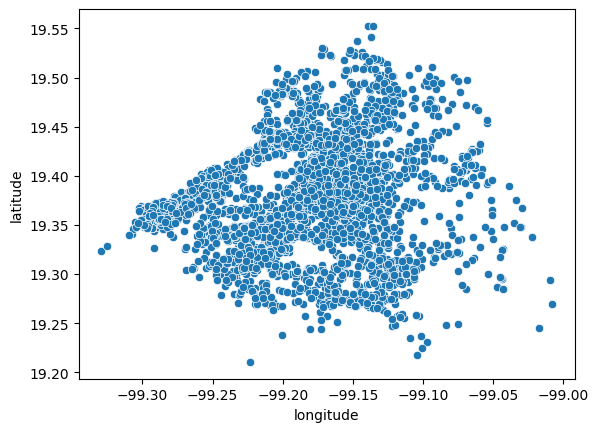

In [15]:
sns.scatterplot(data=df, x="longitude", y="latitude")
plt.show()

In [16]:
num_clusters = 4

# Applying K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(coordinates_data)

# Adding cluster labels to the original data
data_with_labels = np.column_stack((coordinates_data, kmeans.labels_))

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
geo_cluster = data_with_labels[:, 2].astype(int)
df['geo_cluster'] = geo_cluster

Finalmente procedemos a eliminar algunas variables que no usaremos y cambiar el formato de la variable `property_type`.

In [18]:
rm_cols = ['latitude', 'longitude', 'property_id', 'last_observed_date', 'first_observed_date', 'seller_hash', 'marketplace_hash']

In [19]:
cols_ = [x for x in df.columns if x not in rm_cols]

In [20]:
df = df[cols_]

In [21]:
df

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,num_parking_lots,first_price,last_price,views,...,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area,days_between_first_and_last_observed,days_since_last_observed,geo_cluster
0,1,96,apartment,120.0,2.5,2.0,1.0,4100000.0,4100000.0,51,...,0,0,0,0,0,0,0,96,37,1
1,0,37,apartment,82.0,2.0,2.0,2.0,4900000.0,4900000.0,61,...,0,0,0,1,1,0,0,30,7,1
2,1,88,apartment,84.0,2.0,2.0,1.0,2782696.0,2782696.0,50,...,0,0,0,0,0,0,0,88,14,1
3,1,58,apartment,92.0,2.0,2.0,0.0,5280000.0,5280000.0,68,...,0,0,0,1,0,0,0,58,127,1
4,0,95,apartment,55.0,1.0,1.0,1.0,3250000.0,3250000.0,58,...,0,1,0,1,1,0,0,88,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,1,63,apartment,60.0,1.0,1.0,1.6,2900000.0,2900000.0,57,...,0,0,0,0,0,0,0,63,55,3
4736,0,47,house,208.0,2.0,3.0,2.0,5300000.0,5300000.0,56,...,0,0,0,1,0,0,1,40,6,2
4737,1,15,apartment,60.0,1.0,3.0,1.6,1750000.0,1750000.0,62,...,0,0,0,0,0,0,0,15,118,3
4738,1,49,house,302.0,3.0,4.0,2.0,13900000.0,13900000.0,51,...,0,0,0,0,0,0,1,49,55,0


In [22]:
df['property_type'].replace(['apartment', 'house'],
                        [0, 1], inplace=True)

In [23]:
df['property_type'] = df.property_type.astype(int)

In [24]:
df = df[['event', 'property_type', 'surface_total', 'num_bathrooms',
       'num_bedrooms', 'num_parking_lots', 'first_price', 'last_price',
       'views', 'num_marketplaces_property_at', 'has_balcony', 'has_elevator',
       'has_garden', 'has_gym', 'has_luxury_features', 'has_pool',
       'has_studio', 'has_surveillance', 'has_terrace', 'has_visitors_parking',
       'has_washing_area', 'geo_cluster', 'days_since_last_observed',
       'days_between_first_and_last_observed', 'time2event']]

El dataframe que usaremos para la regresión es el siguiente:

In [25]:
df

,event,property_type,surface_total,num_bathrooms,num_bedrooms,num_parking_lots,first_price,last_price,views,num_marketplaces_property_at,...,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area,geo_cluster,days_since_last_observed,days_between_first_and_last_observed,time2event
0,1,0,120.0,2.5,2.0,1.0,4100000.0,4100000.0,51,1,...,0,0,0,0,0,0,1,37,96,96
1,0,0,82.0,2.0,2.0,2.0,4900000.0,4900000.0,61,1,...,0,0,1,1,0,0,1,7,30,37
2,1,0,84.0,2.0,2.0,1.0,2782696.0,2782696.0,50,3,...,0,0,0,0,0,0,1,14,88,88
3,1,0,92.0,2.0,2.0,0.0,5280000.0,5280000.0,68,2,...,0,0,1,0,0,0,1,127,58,58
4,0,0,55.0,1.0,1.0,1.0,3250000.0,3250000.0,58,6,...,1,0,1,1,0,0,3,7,88,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,1,0,60.0,1.0,1.0,1.6,2900000.0,2900000.0,57,2,...,0,0,0,0,0,0,3,55,63,63
4736,0,1,208.0,2.0,3.0,2.0,5300000.0,5300000.0,56,2,...,0,0,1,0,0,1,2,6,40,47
4737,1,0,60.0,1.0,3.0,1.6,1750000.0,1750000.0,62,4,...,0,0,0,0,0,0,3,118,15,15
4738,1,1,302.0,3.0,4.0,2.0,13900000.0,13900000.0,51,1,...,0,0,0,0,0,1,0,55,49,49


In [26]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

Usaremos un algoritmo que nos permita usar variables categóricas y continuas. Una opción bastante probada es XGBoost, que usa gradient boosting para encontrar el objetivo.

In [27]:
model = XGBRegressor()

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
y_pred = model.predict(X_test)


Calculamos nuestra métrica `mean_squared_error` para las predicciones obtenidas a partir del modelo

In [29]:
mean_squared_error(y_pred, y_test)

0.17946155393622912

y obtenemos una gráfica con la importancia de cada feature. Podemos ver que el feature que creamos `days_between_first_and_last_observed` tiene una importancia determinante en nuestra regresión.

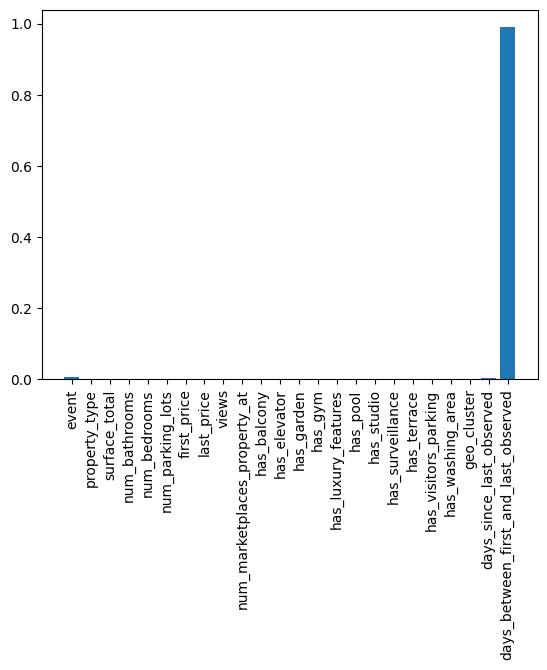

In [30]:
plt.bar(model.feature_names_in_, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

#### ¿Cómo se ve tu análisis para las propiedades que aún no se venden contra las que ya se vendieron?
Podemos calcular las predicciones para casas vendidas y no vendidas separadamente para poder obtener la métrica en cada caso y poder analizar el resultado.

In [31]:
X_test_vend = X_test[X_test['event'] == 1] # vendidas
X_test_no_vend = X_test[X_test['event'] == 0] # no vendidas

In [32]:
y_pred_vend = model.predict(X_test_vend)
y_pred_no_vend = model.predict(X_test_no_vend)

In [33]:
y_test_vend = y_test[X_test_vend.index]
y_test_no_vend = y_test[X_test_no_vend.index]

In [34]:
mean_squared_error(y_pred_vend, y_test_vend)

0.06246892552116077

In [35]:
mean_squared_error(y_pred_no_vend, y_test_no_vend)

0.3446801513162875

Como se puede ver, claramente hay una mejor predicción para propiedades vendidas y suponemos que esto se debe a la cercanía de la variable `days_between_first_and_last_observed` a la variable target `time2event`. Esto coincide con lo que se estableció al principio del presente trabajo respecto a cómo se obtiene `time2event`.